# Example 2: Reinforcement learning with a two-armed bandit.

This is an **intermediate** level tutorial, where we assume that you are familiar with the basics of reinforcement learning and the two-armed bandit problem.
In this example, we will apply and fit a reinforcement learning model to a two-armed bandit problem.
The model will be consist of a $\epsilon$-greedy policy and a prediction error term.

In the following tutorial, we will use `prettyformatter` to print some nice and organised output in the Jupyter Notebook.
In your python script, you do not need to use `prettyformatter`.


## Two-armed bandits

Two-armed bandit is a two-alternative forced-choice reinforcement learning problem, part of the bigger set of multi-armed bandit problems. 
In these problems, the person is faced with multiple choices, each with a different degree of reward.
The goal of the person is to learn which choice is the best and to maximize the reward over time.
In this example, we will consider a two-armed bandit problem, where the person is faced with two choices (select an item on the left or the item on the right), each with a different reward.
There are 4 different items that can appear in combinations of two, and the reward for each item varies.
For example, if item 1 has a chance of 0.7 of giving a reward, then you can expect to receive a reward 70% of the time when you select item 1.
The problem is that the underlying structure of the item-reward mapping is unknown.
Here we will use the following item-reward mapping:

| Item | Reward |
|------|--------|
| 1    | 0.8    |
| 2    | 0.2    |
| 3    | 0.5    |
| 4    | 0.9    |

## Import the data

First, we will import the data and get it ready for the toolbox.

In [86]:
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prettyformatter import pprint

experiment = pd.read_csv('bandit.csv', header=0)
experiment.head(10)

,stimulus_left,stimulus_right,reward_left,reward_right,ppt
0,4,3,0.0,1.0,1
1,1,4,0.0,1.0,1
2,4,2,0.0,0.0,1
3,1,2,1.0,1.0,1
4,4,3,0.0,0.0,1
5,3,4,1.0,1.0,1
6,2,3,0.0,0.0,1
7,3,4,1.0,0.0,1
8,4,3,0.0,0.0,1
9,3,4,0.0,0.0,1


Let us look at what each column represents:

- `left`: the stimulus presented on the left side.
- `right`: the stimulus presented on the right side.
- `reward_left`: the reward received when the left stimulus is selected.
- `reward_right`: the reward received when the right stimulus is selected.
- `ppt`: the participant number.

Notice that for now, we don't have any actual data recorded from participants.
That is because, for now, we will only import the environment, containing all states and rewards.
So, let us convert the data into a format that the toolbox can understand.

Fortunately, the toolbox provides a function to convert the data into the required format.
We will use the `pandas_to_dict` function available in the `cpm.utils` module.



In [91]:
from cpm.utils import pandas_to_dict

experiment = pandas_to_dict(experiment, participant="ppt", stimuli='stim', feedback='reward')
length = len(experiment)
print(f"Number of participants: {length}")

Number of participants: 100


Here, we have a list of dictionaries, where each dictionary represents an experimental session that a participant might complete.
If you have 100 participants or sessions, then you will have 100 dictionaries in the list -each with their unique trial order (schedule).

In [92]:
print(f"Key variables in the dictionary: {experiment[0].keys()}")
print(f"Number of trials and number of the stimuli on each of those trials: {experiment[0].get('trials').shape}")
print(f"Number of trials and number of the feedback on each of those trials: {experiment[0].get('feedback').shape}")
print("All looks good! We are ready to go!")


Key variables in the dictionary: dict_keys(['trials', 'feedback', 'ppt'])
Number of trials and number of the stimuli on each of those trials: (60, 2)
Number of trials and number of the feedback on each of those trials: (60, 2)
All looks good! We are ready to go!



Let us see what each value within the dictionary represents:

- `trials`: the stimuli presented in the session. It must be a 2D numpy.ndarray (a matrix). Each row represents a trial, and the columns represent the left and right stimuli presented in each trial.
- `feedback`: the rewards that could be obtained from the stimuli. It must be a 2D numpy.ndarray (a matrix). Each row represents a trial, and the columns represent the reward that could be obtained from the corresponding stimulus in the `stimuli` key.

## The model

Let us quickly go through the model we will use.

Each stimulus has an associated value, which is the expected reward that can be obtained from selecting that stimulus.

Let $Q(a)$ be the estimated value of action $a$.
On each trial, $t$, there are two stimuli present, so that $Q(a)$ could be $Q(\text{left})$ or $Q(\text{right})$, where the corresponding Q-values are derived from the associated value of the stimuli present on left or right.
More formally, we can say that the expected value of the action $a$ selected at time $t$ is given by:

$$
Q_t(a) = \mathbb{E}[R_t | A_t = a]
$$

where $R_t$ is the reward received at time $t$, and $A_t$ is the action selected at time $t$.

On each trial $t$, the Softmax policy will select an action (left or right) based on the following policy:

$$
P(a_t) = \frac{e^{Q_{a, t} \epsilon}}{\sum_{a = 0}^{k}{e^{Q_{t} \epsilon}}}
$$

where
So, on each trial, the model will select an action (left or right) based on the following policy:

$$
A_t = \begin{cases}
\text{left} & \text{with probability } P(\text{left}) \\
\text{right} & \text{with probability } P(\text{right})
\end{cases}
$$

where $A_t$ is the action selected at time $t$, and $Q_t(a)$ is the estimated value of action $a$ at time $t$.

The model will calculate the prediction error according to the following learning rule:

$$
\Delta Q_t(A_t) = \alpha \times \Big[ R_t - Q_t(A_t) \Big]
$$

where $\alpha$ is the learning rate, and $R_t$ is the reward received at time $t$.
Note that this rule is often reported as the Rescorla-Wagner learning rule, where for each action/outcome, the prediction error is the difference between the reward received and the sum of all values present on each trial for that action.
In our case, we only have one value for each action, so the Rescorla-Wagner learning rule is reduced to the Bush and Mosteller separable error term.
Q-values are then updated as follows:

$$
Q_{t+1}(A_t) = Q_t(A_t) + \Delta Q_t(A_t)
$$

### Building the model

In order to use the toolbox, you will have to specify **the computations for one single trial**.
Rest assured, you do not have to build the model from scratch.
We have fully-fledged models in `cpm.applications` that you can use, but we also have all the building blocks in `cpm.components` that you can use to build your own model.

For now, let us simplify the problem and start by specifying what information we need on each trial.
Here, we are only concerned about the environment, and not the participant's choices or model parameters.
This information will usually be extracted from the data we just imported.
Here, we create this to help us develop the model.

Here, we need to specify the following:

- `trials`: the stimuli presented in the trial. It must be a 1D numpy.ndarray (a vector) with two elements, representing the left and right stimuli presented in the trial. For example, if stimuli 1 and 4 was presented, then the vector would be [1, 4].
- `feedback`: the rewards that could be obtained from selecting the stimuli - essentially the feedback about the choice the model makes. It must be a 1D numpy.ndarray (a vector) with two elements, representing the reward that could be obtained from the left and right stimuli presented in the trial. For example, if the outcome for selecting the left stimulus was 1 and the outcome for selecting the right stimulus was 0, then the vector would be [1, 0].

You can specify as many other variables as you need, but these are the minimum required to build the model.
All variables specified here must also be `array_like` objects (e.g., numpy arrays, lists, etc.).

In [4]:
trial = {
    "trials": [1, 4],
    "feedback": [1, 0]
}

Now, before we build the model, we also have to talk about the `cpm.Parameter` class.
This class is used to specify the parameters of the model, including various bounds and priors.
Let us specify the parameters for the model.

In [108]:
from cpm.generators import Parameters

parameters = Parameters(alpha = 0.1, epsilon = 0.5, values = np.array([0.25, 0.25, 0.25, 0.25]))
print(f"The learning rate of the model: {parameters.alpha.export()}")
print(f"The exploration rate of the model: {parameters.epsilon.export()}")
print(f"The initial value of each action: {parameters.values.export()}")

The learning rate of the model: {'value': 0.1, 'prior': 'normal', 'lower': 0, 'upper': 1}
The exploration rate of the model: {'value': 0.5, 'prior': 'normal', 'lower': 0, 'upper': 1}
The initial value of each action: {'value': array([0.25, 0.25, 0.25, 0.25]), 'prior': 'normal', 'lower': 0, 'upper': 1}


You can immediately see that the toolbox defined a bunch of things for us.
This includes the prior and the parameter ranges as well.
One thing we have to clarify is the value for each action.
Here we initialised the value of each action to 0.25.
You can initialise it to 0 as well, which is a common practice.
If you use a rating scale in your experiment and use a Logistic function for your choice rule, the number you initialise the value will make a difference.
The way you represent the values will also depend on the model building blocks you use and how you specify the computations for each trial.
Nonetheless, even though we treated it as a parameter, we do not need to estimate it later on.

That was enough preparation, let us build a model.

In [109]:
from cpm.models import learning, decision, utils
import copy

def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    epsilon = parameters.epsilon
    values = np.array(parameters.values) # copy essentially prevents us from accidentally overwriting the original values
    # pull out the trial information
    stimulus = np.array(trial.get('trials'))
    feedback = np.array(trial.get("feedback"))
    teacher = np.zeros(4) # teaching signal, reward signal for the learning term
    mute = np.zeros(4)  # mute learning for all cues not presented

    # activate the value of each available action
    # here there are two possible actions, that can take up on 4 different values
    # so we subset the values to only include the ones that are activated...
    # ...according to which stimuli was presented
    activation = values[stimulus - 1]
    # convert the activations to a 2x1 matrix, where rows are actions/outcomes
    activations = activation.reshape(2, 1)
    # calculate a policy based on the activations
    response = decision.Softmax(activations=activations, temperature=epsilon)
    response.compute() # compute the policy
    choice = response.choice() # get the choice based on the policy
    reward = feedback[choice] # get the reward of the chosen action

    
    # update the value of the chosen action
    teacher[stimulus[choice] - 1] = reward # update the teacher's value of the chosen action
    mute[stimulus[choice] - 1] = 1 # unmute the learning for the chosen action
    update = learning.SeparableRule(weights=values, feedback=teacher, input=mute, alpha=alpha)
    update.compute()
    values += update.weights.flatten()
    ## compile output
    output = {
        "policy"   : response.policies,         # policies
        "response" : choice,                    # choice based on the policy
        "reward"   : reward,                    # reward of the chosen action
        "values"   : values,                    # updated values
        "change"   : update.weights,            # change in the values
        "activation" : activations.flatten(),     # activation of the values
        "dependent"  : response.policies,        # dependent variable
    }
    return output

model(parameters, trial)

{'policy': array([0.5, 0.5]),
 'response': 1,
 'reward': 0,
 'values': array([0.25 , 0.25 , 0.25 , 0.225]),
 'change': array([[-0.   , -0.   , -0.   , -0.025]]),
 'activation': array([0.25, 0.25]),
 'dependent': array([0.5, 0.5])}

The important bit here is that `values`, `response` and `policy` must be returned by the function you specify.
They will be used by other methods in the toolbox to indentify key variables.

`values` and `policy` must be numpy arrays, and `response` could be either an array, int, or float, depending on what the dependent variable is.

### Simulate data

In [110]:
from cpm.generators import Simulator, Wrapper

wrapper = Wrapper(model=model, parameters=parameters, data=experiment[6])
wrapper.run()

Now we have ran the model on a single session, let's investagete the output.
`cpm` is great for this because everything that you might need to look at is stored inside the `Wrapper` object.

In [111]:
pprint({"Action value associated with stimuli at the end of training" : wrapper.values.round(3)}, depth = 2)
pprint({"Model output on last trial" : wrapper.simulation[len(wrapper.simulation) - 1]}, depth = 2)

{"Action value associated with stimuli at the end of training": array([0.467, 0.038, 0.034, 0.038])}
{
      "Model output on last trial":
          {
              "policy": array([0.5, 0.5]),
              "response"  : 1,
              "reward": 1.0,
              "values": array([0.4671325 , 0.03752366, 0.03377129, 0.03752366]),
              "change": array([[-0.        , -0.        , -0.00375237, -0.        ]]),
              "activation": array([0.03752366, 0.03752366]),
              "dependent" : array([0.5, 0.5]),
          },
  }


Let us do a complete experiment with 100 participants, and then we will look at the output.

In [112]:
simulation = Simulator(model=wrapper, parameters=parameters, data=experiment)

simulation.run()

/opt/homebrew/lib/python3.11/site-packages/cpm/generators/simulator.py:59: UserWarning: The number of parameter sets and number of participants in data do not match.
Using the same parameters for all participants.
  warnings.warn(


Let us look at how the model fares in solving the bandit problem.

<Axes: xlabel='trial'>

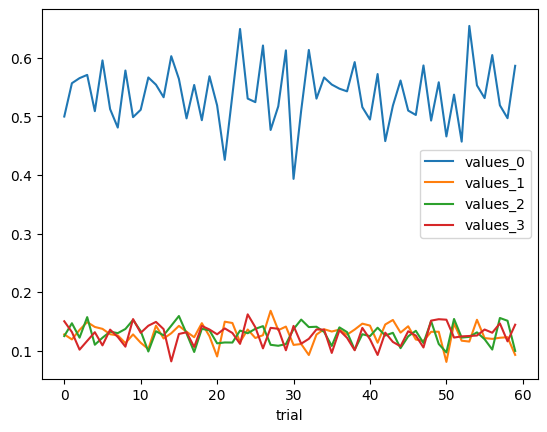

In [113]:
data = simulation.export()
data.reset_index()
data["trial"] = pd.Index(np.repeat(range(0, 60), 100))
data["id"] = pd.Index(range(0, data.shape[0]))
subset = data.iloc[:, [4, 5, 6, 7, 16, 17, 18]]

subset.groupby("trial").mean().plot(y=["values_0", "values_1", "values_2", "values_3"], kind="line")

The model almost always selects the best stimulus, and the value of the best stimulus increases over time.
Compared to this, the other values are really low in comparison, but they are different from each other, which means that the model can distinguish between them.
With more trials, the stimuli will be selected more often, and the action values will converge to the true values.

## Parameter Recovery

In [115]:
from cpm.evaluation import ParameterRecovery, strategies
from cpm.optimisation import minimise, DifferentialEvolution


lower = [1e-10, 1e-10]
upper = [1, 1]
bounds = list(zip(lower, upper))

template = {"alpha": 0.5, "epsilon": 0.5}

new = Simulator(model=wrapper, parameters=template, data=experiment)
loss = minimise.LogLikelihood.continuous

recovery = ParameterRecovery(
    model=new, 
    iteration=10,
    bounds=bounds,
    optimiser=DifferentialEvolution,
    loss=loss,
    )

recovery.recover()

Let us look at some plots to see how well the model can recover the parameters.

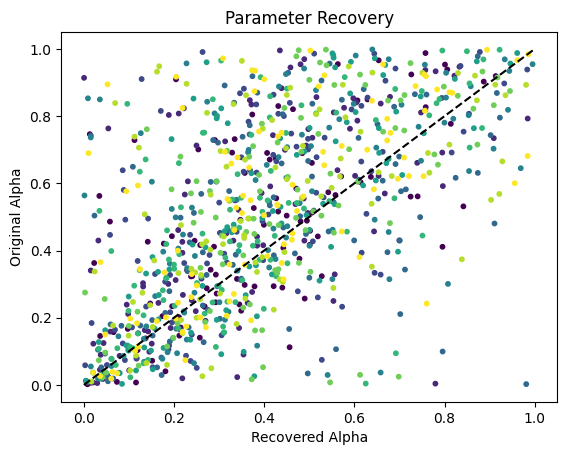

In [125]:
alpha = recovery.extract(key = "alpha")
plt.scatter(alpha["recovered"], alpha["original"], c=alpha["iteration"], s=10)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Recovered Alpha")
plt.ylabel("Original Alpha")
plt.title("Parameter Recovery")
plt.show()


This is unfortunate.
The learning rate is somewhat recoverable, but it is not as good as we might expect.
This suggests that our model is either misspecified or that the learning rate is less identifiable.
One reason it might be the case is because in our experiment, you only receive feedback on the action you selected.
The softmax function will be more influential then the learning rate when the feedback is sparse.
This worsens with only a few trials, and the learning rate becomes less important.
The model requires many more trials to succeed in recovering the learning rate.


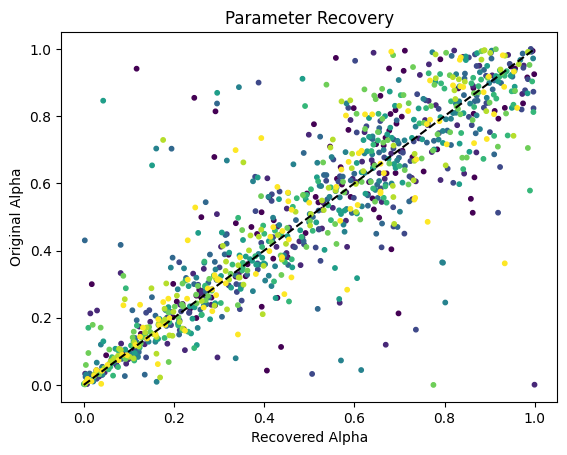

In [128]:
epsilon = recovery.extract(key = "epsilon")
plt.scatter(epsilon["recovered"], epsilon["original"], c=epsilon["iteration"], s=10)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Recovered Alpha")
plt.ylabel("Original Alpha")
plt.title("Parameter Recovery")

plt.show()


As you can see here, the inverse temperature is well recovered and easily identifiable.
This makes sense, as this has more impact on the model's behaviour than the learning rate - what you select impacts what you learn.


# Summary

Here, we used the toolbox to build a model, simulate data, and recover the parameters.
We found that the model was able to recover the inverse temperature, but has less success at recovering the learning rate, which is likely due to the softmax rule and the small number of trials in the experiment.
We did so without having to write any complex code, and we were able to use the toolbox to do most of the heavy lifting for us.